# Dataset Generation: Positive vs Blank (Unbalanced)

## Purpose

This notebook constructs a training dataset for binary classification using only:

- Positive samples (`LABEL == 1`) — Porphyry copper deposits
- Blank area samples (`LABEL == 0`) — Areas without known mineralization

It **excludes all `other_deposit` samples** to avoid label noise and ensure clean class separation.

---

## Input Files

- `positive_augmented_patch.csv`: Positive samples with geophysical features
- `negative_blank_samples.csv`: Negative samples randomly sampled from blank (non-mineralized) areas

---

## Output

- Merged dataset: `train_dataset_pos_vs_blank.csv`
- Contains all positive and blank samples, unbalanced as in real-world conditions
- Shuffled and ready for training split and scaling

---

## Usage

This dataset is suitable for:

- Training models with `class_weight="balanced"` or `SMOTE`
- Baseline model evaluation with real-world class proportions
- Avoiding misleading results caused by overly balanced toy datasets

# 📘 06_generate_all_samples_unbalanced_only_merge_blank_samples.ipynb

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [4]:
# === Step 1: Define paths ===
POSITIVE_PATH = "../../data/processed/positive_augmented_patch.csv"
NEG_BLANK_PATH = "../../data/processed/negative_blank_samples.csv"
OUTPUT_PATH = "../../data/processed/final_samples_unbalanced_pos_vs_blank.csv"

In [5]:
# === Step 2: Load datasets ===
df_pos = pd.read_csv(POSITIVE_PATH)
df_blank = pd.read_csv(NEG_BLANK_PATH)

print(f"Loaded {len(df_pos)} positive samples")
print(f"Loaded {len(df_blank)} blank area samples")


Loaded 950 positive samples
Loaded 3979 blank area samples


In [6]:
# === Step 3: Merge datasets ===
df_combined = pd.concat([df_pos, df_blank], ignore_index=True)
df_combined = df_combined.sample(frac=1.0, random_state=42).reset_index(drop=True)  # Shuffle

print(f"Combined dataset shape: {df_combined.shape}")
print(df_combined['LABEL'].value_counts())

Combined dataset shape: (4929, 5)
LABEL
0    3979
1     950
Name: count, dtype: int64


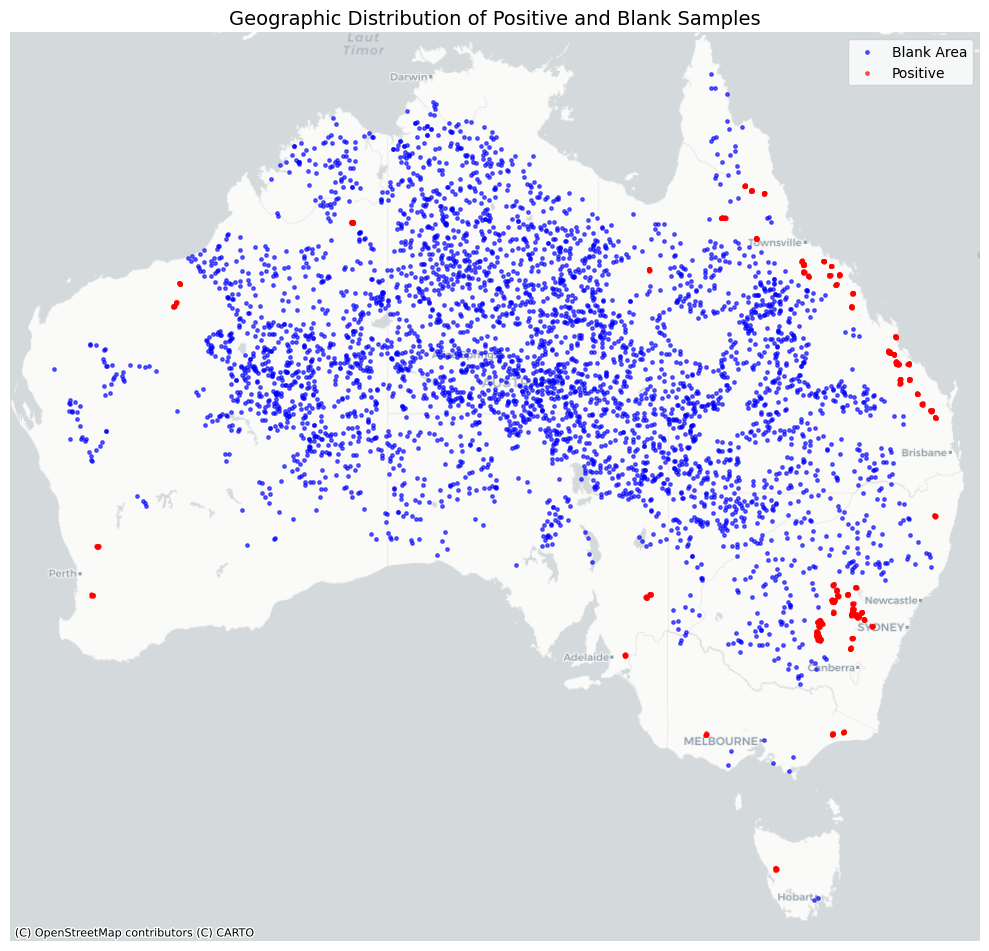

In [11]:
# === 4. Visualization ===
# Check required columns
assert "LONGITUDE" in df_combined.columns and "LATITUDE" in df_combined.columns, "Missing coordinates"

# Create GeoDataFrame with WGS84
gdf = gpd.GeoDataFrame(
    df_combined,
    geometry=gpd.points_from_xy(df_combined.LONGITUDE, df_combined.LATITUDE),
    crs="EPSG:4326"
)

# Reproject to Web Mercator for basemap
gdf = gdf.to_crs(epsg=3857)

# Color mapping
label_map = {0: "blank_area", 1: "positive"}
color_map = {"blank_area": "blue", "positive": "red"}

# Create plot
fig, ax = plt.subplots(figsize=(10, 12))

# Plot each class separately
for label, group in gdf.groupby("LABEL"):
    label_name = label_map[label]
    group.plot(
        ax=ax,
        markersize=6,
        color=color_map[label_name],
        label=label_name.replace("_", " ").title(),
        alpha=0.6
    )

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Geographic Distribution of Positive and Blank Samples", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
# === Step 5: Save to output file ===
df_combined.to_csv(OUTPUT_PATH, index=False)
print(f"Merged dataset saved to: {OUTPUT_PATH}")

Merged dataset saved to: ../../data/processed/final_samples_unbalanced_pos_vs_blank.csv
